```{eval-rst}
.. include:: sinebow.rst

```
{sinebow24}`Logo`
==================

This is a little cute: Omnipose can "segment" text using the `bact_phase_omni` model. Semantic segmentation of uniform, 
disjoint shapes on a uniform background is absolutely no feat, but it is amusing that a neural network trained purely on
phase contrast images of bacteria gives such reasonable output on something so different from the training set. 
Also, the over-segmentation at cusps hints that the network has learned to pick up on local morphology. 

To make the Omnipose logo/title/favicon, I first generate some rasterized text images with roughly the same mean diameter as the bacteria in my training set: 

In [ ]:
%load_ext autoreload
%autoreload 2

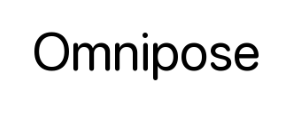

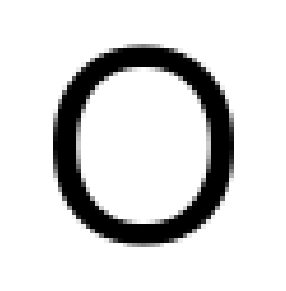

In [ ]:
# Make some text images

from PIL import Image, ImageDraw, ImageFont
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('dark_background')
import matplotlib as mpl
%matplotlib inline
mpl.rcParams['figure.dpi'] = 300

from omnipose.utils import bbox_to_slice

tsizes = [60]
texts = ["Omnipose","O"]
imgs = []
for textsize in tsizes:
    fonts = [ImageFont.truetype(f, textsize) for f in ["SFNSRounded.ttf"]]
    # fonts = [ImageFont.truetype(f, textsize) for f in ["Arial.ttf"]]
    for text in texts:
        for font in fonts:
            size = np.array([textsize*len(text)*2, textsize*2])
            im = Image.new("RGB", tuple(size), "white")
            d = ImageDraw.Draw(im)
            center = size/2
            anchor = "mm"
            d.text(center, text, fill="black", anchor=anchor, font=font)
            bbox = d.textbbox(center, text, anchor=anchor, font=font)
            bbox = [bbox[1],bbox[0],bbox[3],bbox[2]] # reverse x, y
            im = np.array(im)
            shape = im.shape[:2]
            slc = bbox_to_slice(bbox,shape,pad = 3)
            im = im[slc]
            imgs.append(im)
        

            fig = plt.figure(figsize=(1,1))
            fig.patch.set_facecolor([0]*4)
            
            
            plt.imshow(im)
            plt.axis('off')
            plt.show()

## Segmentation
I will then segment these image with the standard settings:

2023-08-03 20:42:12,194 [INFO] ** TORCH GPU version installed and working. **
2023-08-03 20:42:12,194 [INFO] >>bact_phase_omni<< model set to be used
2023-08-03 20:42:12,195 [INFO] ** TORCH GPU version installed and working. **
2023-08-03 20:42:12,195 [INFO] >>>> using GPU


  0%|          | 0/2 [00:00<?, ?it/s]

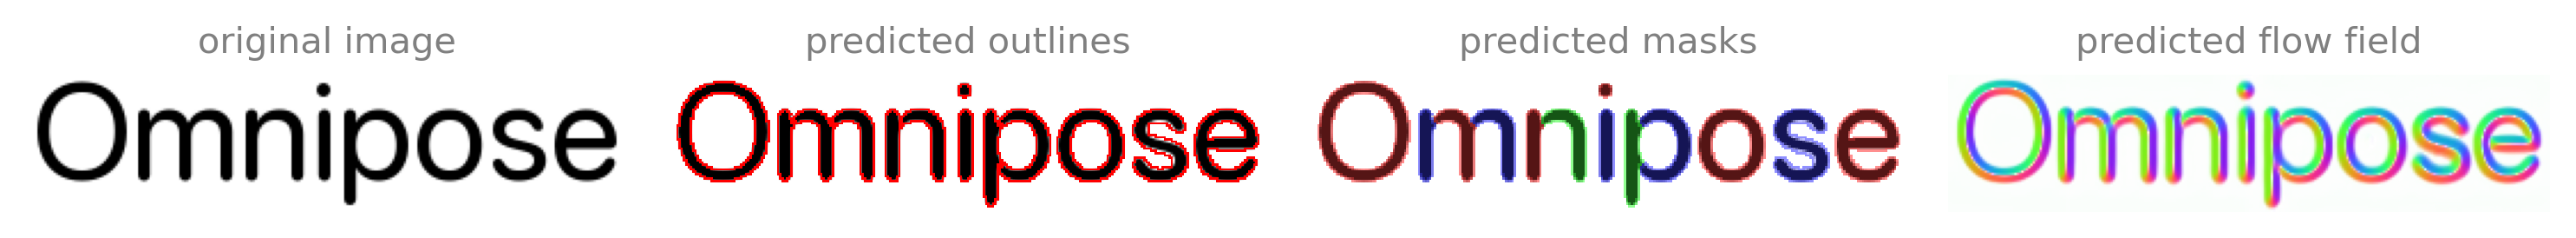

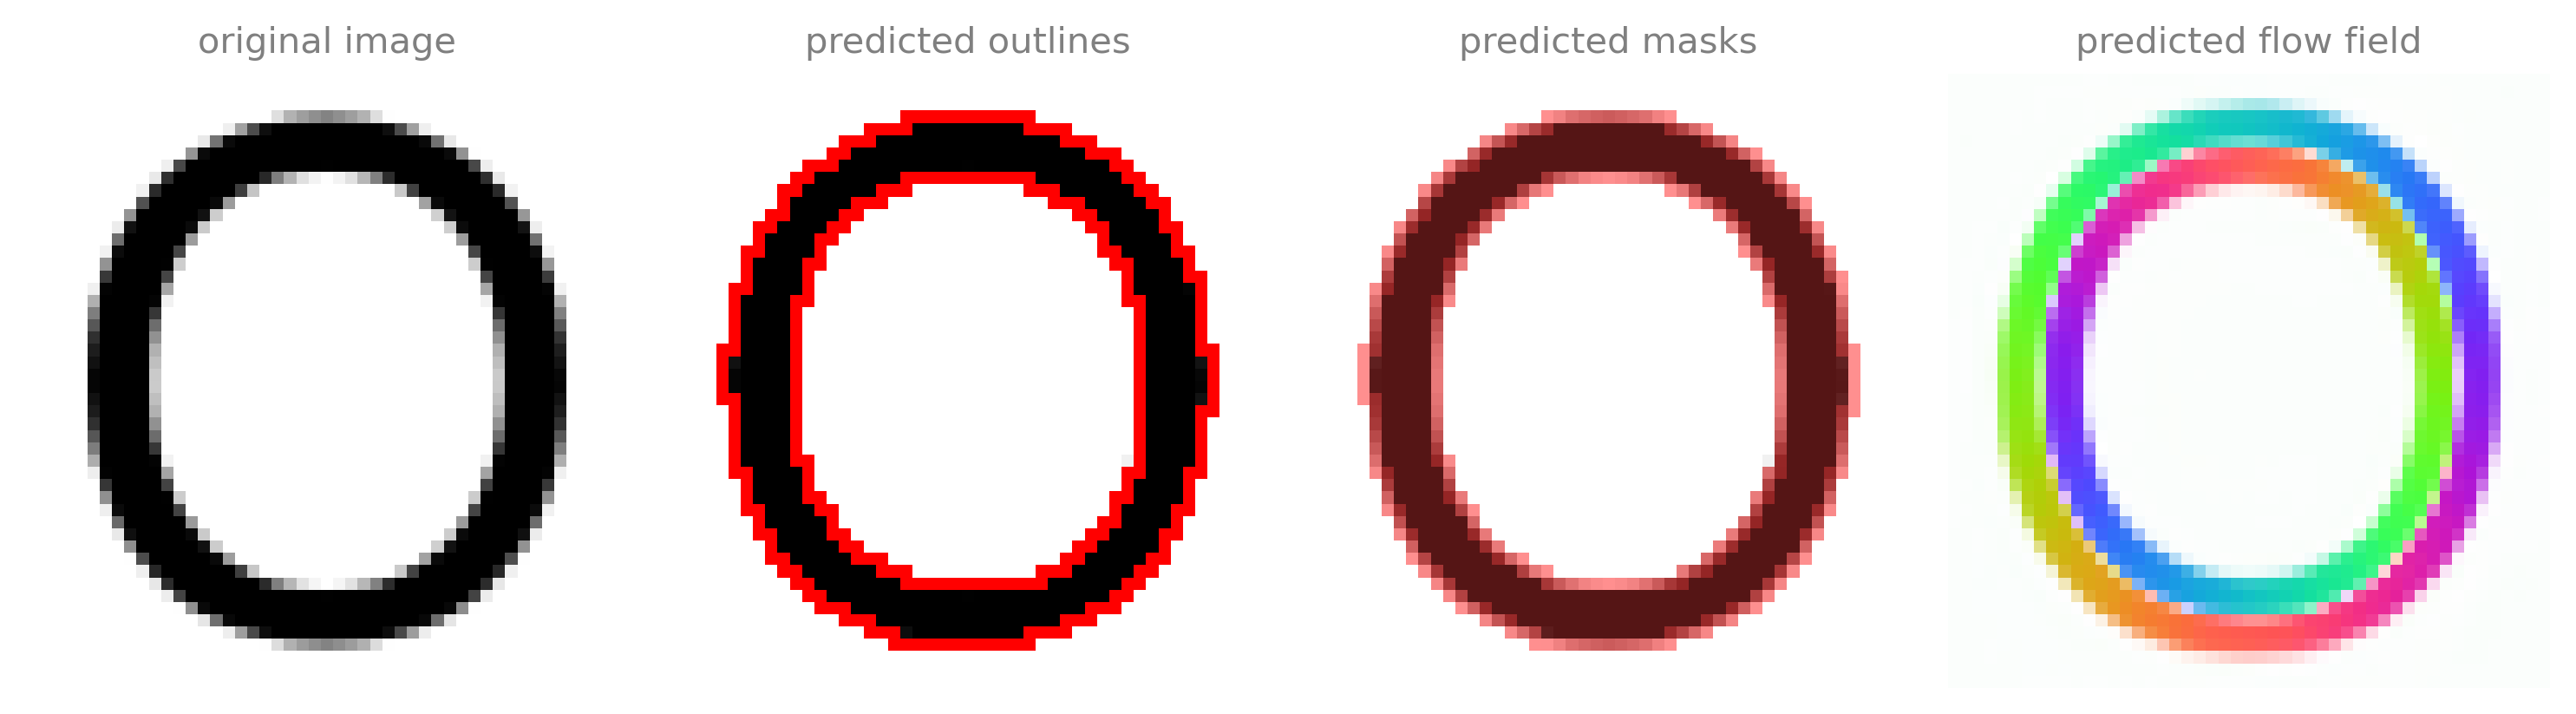

In [ ]:
from cellpose_omni import plot, models, core
import omnipose

model_name = 'bact_phase_omni'
use_GPU = core.use_gpu()
model = models.CellposeModel(gpu=use_GPU, model_type=model_name)


chans = [0,0] #this means segment based on first channel, no second channel 
nimg = len(imgs)
n = range(nimg) 

# define parameters
mask_threshold = 1
verbose = 0 
use_gpu = use_GPU 
transparency = True 
rescale=None
omni = True 
flow_threshold = 0 
resample = True 
cluster = False

masks, flows, styles = model.eval([imgs[i] for i in n],
                                  channels=chans,
                                  rescale=rescale,
                                  mask_threshold=mask_threshold,
                                  transparency=transparency,
                                  flow_threshold=flow_threshold,
                                  omni=omni,resample=resample,
                                  verbose=verbose, 
                                  cluster=cluster)


mpl.rcParams['figure.dpi'] = 300
plt.style.use('dark_background')

for idx,i in enumerate(n):

    maski = masks[idx] # get masks
    bdi = flows[idx][-1] # get boundaries
    flowi = flows[idx][0] # get RGB flows 

    # set up the output figure to better match the resolution of the images 
    # f = 10
    # szX = maski.shape[-1]/mpl.rcParams['figure.dpi']*f
    # szY = maski.shape[-2]/mpl.rcParams['figure.dpi']*f
    szX,szY = 10,10
    fig = plt.figure(figsize=(szY,szX*4))
    fig.patch.set_facecolor([0]*4)
    
    plot.show_segmentation(fig, omnipose.utils.normalize99(imgs[i]), 
                           maski, flowi, bdi, channels=chans, omni=True, interpolation=None)

    plt.tight_layout()
    plt.show()

I landed on this font because it is one of Apple's system defaults (and therefore works well with the system fonts used on our website when viewed on Apple devices), and I chose this scale because it is very close to bacteria and showed a good amount of 'segmentation' in the M, N, P, and E from purely local morphology (cusps). This gives reasonable output at higher-resolution text (wider 'cells'), but it starts to hallucinate output between objects if the size gets too large. 


## Adjusting transparency 
The transparency (alpha channel) is set by the flow magnitude, and the color (RGB channels) is set by the flow angle according to a shifted sinebow relation:
```python
angles = np.arctan2(dP[1], dP[0])+np.pi
r = ((np.cos(angles)+1)/2)
g = ((np.cos(angles+2*np.pi/3)+1)/2)
b =((np.cos(angles+4*np.pi/3)+1)/2)
```
(a is just a constant, not alpha). The slight tinge of green comes from the fact that {py}`np.arctan2(0,0)=0` and {py}`((np.cos(0+2*np.pi/3)+1)/2) = 1/4`. I'll try two ways to remove it: 
first by removing any average background bias, second by adjusting the alpha channel so that the background alpha is 0 on average. 

avarage bias is [0.06506971, 0.06305661], average angle is 0.24499917011957278 pi rad.


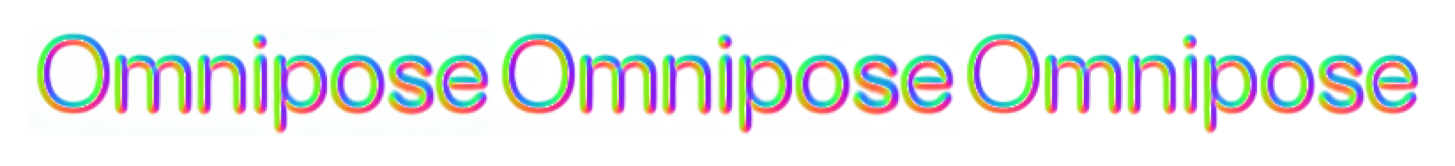

avarage bias is [0.07233106, 0.06707774], average angle is 0.23801084309752654 pi rad.


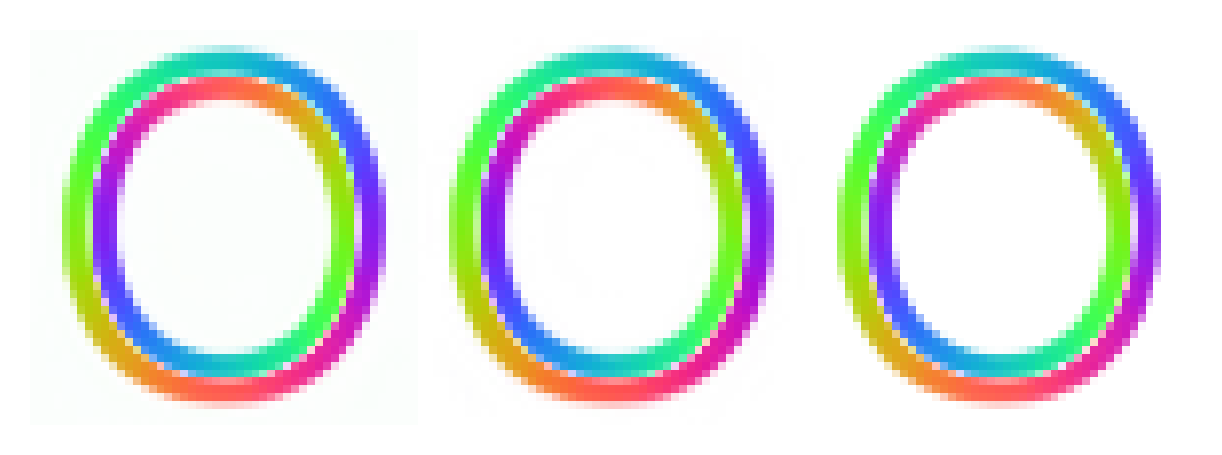

In [ ]:
import skimage.io
import os
from omnipose.utils import normalize99, rescale
from scipy.ndimage import zoom
from pathlib import Path

omnidir = Path(omnipose.__file__).parent.parent
basedir = os.path.join(omnidir,'docs','_static')
names = ['logo.png','icon.ico']
ext = '.png'

for idx,i in enumerate(n):

    maski = masks[idx]
    flowi = flows[idx][0]
    dPi = flows[idx][1]
    bias = [np.mean(d[maski==0]) for d in dPi]
    angle = np.arctan2(bias[1], bias[0]) / np.pi
    print('avarage bias is {}, average angle is {} pi rad.'.format(bias,angle))
    dPi_new = np.stack([np.clip(d - b,-np.inf,np.inf) for d,b in zip(dPi,bias)])
    flowi_new = plot.dx_to_circ(dPi_new,transparency=True)
    
    flowi_3 = flowi.copy()
    alpha = flowi_3[...,-1]
    flowi_3[...,-1] = rescale(np.clip(alpha-np.mean(alpha[maski==0]),0,np.inf))*255
    
    f = 30
    szX = maski.shape[-1]/mpl.rcParams['figure.dpi']*f
    szY = maski.shape[-2]/mpl.rcParams['figure.dpi']*f
    fig = plt.figure(figsize=(szY,szX*4))
    fig.patch.set_facecolor([0]*4)
    
    plt.imshow(np.hstack([flowi,flowi_new,flowi_3]))
    plt.axis('off')
    plt.show()
    # aplha channel correction is the winner
    # also rescale the image without interpolation so that, when displayed as favicon etc., it is not as smoothed out - we want to show real output 
    skimage.io.imsave(os.path.join(basedir,names[idx]),zoom(flowi_3,(3,)*(flowi.ndim-1)+(1,),order=0)) 
    

Turns out that subtracting off the flow component bias introduces some over-correction in places, leading to some discoloration. So, alpha adjustment it is. It might be hard for you to see it, but I can. This level of pixel-peeping is how I made my ground-truth data ;-) 

## Exporting
Favicons need to be a particular resolution. For now I am making a multi-scale .ico, but that isn't working properly on Safari (too pixelated). Seems like multiple separate PNGs is the way to go moving forward. 

In [ ]:
from PIL import Image
filename = os.path.join(basedir,names[-1])
zimgs = []

for j,sz in enumerate([(32,32), (128,128), (180,180), (192,192)]):
    scale = np.array(sz)/np.array(flowi_3.shape[0:2])
    zimg = zoom(flowi_3,tuple(scale)+(1,),order=(np.max(scale)<1)) 
    zimgs.append(zimg)
    # plt.imshow(zimg)
    # plt.axis('off')
    # plt.show()
    # zimg.shape

icon = Image.fromarray(zimgs[0], 'RGBA')
icon.save(filename,append_images=[Image.fromarray(z, 'RGBA') for z in zimgs[1:]])